# 

[Insprired by](https://towardsdatascience.com/reinforcement-learning-implement-tictactoe-189582bea542), see also chapter 6.5 of Sutton etal. 

- https://towardsdatascience.com/simple-reinforcement-learning-q-learning-fcddc4b6fe56
- https://en.wikipedia.org/wiki/Q-learning
- https://www.learndatasci.com/tutorials/reinforcement-q-learning-scratch-python-openai-gym/

In [4]:
import numpy as np
import pandas as pd
import copy

class Tictoe:
    def __init__(self, size):
        self.size = size
        self.board_size = size*size
        self.board = np.zeros(self.board_size)
        self.letters_to_move = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i'][:self.board_size]
        self.possible_next_moves = copy.deepcopy(self.letters_to_move)
        self.moves_made = ''
    def reset_board(self):
        self.board = np.zeros(self.board_size)
        self.letters_to_move = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i'][:self.board_size]
        self.possible_next_moves = copy.deepcopy(self.letters_to_move)
        self.moves_made = ''
    def get_board(self):
        return self.board.reshape([self.size, self.size])
    def make_move(self, who, where, verbose=False):
        self.board[self.letters_to_move.index(where)] = who
        self.moves_made += where
        self.possible_next_moves.remove(where)
        if verbose:
            print(self.get_board())
            print('Is game done?: ', self.is_endstate())
        return [self.moves_made, self.get_reward(who)]
    def get_sums_of_board(self):
        local_board = self.get_board()
        return np.concatenate([local_board.sum(axis=0),             # columns
                               local_board.sum(axis=1),             # rows
                               np.trace(local_board),               # diagonal
                               np.trace(np.fliplr(local_board))], axis=None)   # other diagonal
    def is_endstate(self):
        someone_won = len(np.intersect1d((self.size, -self.size), self.get_sums_of_board())) > 0
        draw = np.count_nonzero(self.board) == (self.size * self.size) - 1
        return someone_won or draw
    def get_reward(self, who):
        sums = self.get_sums_of_board()
        if self.size in sums:       # The 1 player won
            #print('1.', end='')
            return who * 10
        elif -self.size in sums:    # The -1 player won
            #print('-1.', end='')
            return who * -10
        elif np.count_nonzero(self.board) == (self.size * self.size) - 1:  # Draw
            #print('0.', end='')
            return 5
        else:
            return 0  # Favor shorter games, i.e. taking the fastest road to victory. 
    def get_moves_made(self):
        return self.moves_made
    def get_current_state(self):
        return self.moves_made
    def get_possible_next_states(self):
        return [self.moves_made + next_move for next_move in self.possible_next_moves]
    def get_possible_next_moves(self):
        return self.possible_next_moves.copy()  # Make a copy to ensures things work out in the game loop when we make the next move

In [5]:
tactoe = Tictoe(3)
tactoe.get_possible_next_moves()

['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i']

# Make the Q-table

In [152]:
import random
from tqdm import tqdm

def keywithmaxval(d):
     """ a) create a list of the dict's keys and values; 
         b) return the key with the max value
         
         
     Copied from https://stackoverflow.com/questions/268272/getting-key-with-maximum-value-in-dictionary"""  
     v=list(d.values())
     k=list(d.keys())
     return k[v.index(max(v))]

class Player:
    def __init__(self, id, alpha = 0.5, gamma = 0.6, epsilon = 0.1):
        self.qtable = {}
        self.id = id
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
    def get_qtable(self):
        return self.qtable
    def get_id(self):
        return self.id
    def set_params(self, 
                   alpha = 0.5,       # How fast do we learn from new info
                   gamma = 0.6,       # How much are we focused on the short or the long term. 1 = max long term, 0 is max short term
                   epsilon = 0.1):    # exploration vs exploitation
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
    def make_move(self, game, opponent_qtable, verbose=False):
        if game.is_endstate():
            # If the game is done by the time we get to make a move, simply skip this step
            return game
        # Make a choice what move to take next
        possible_moves = game.get_possible_next_moves()
        current_state = game.get_current_state()
        
        # If the current_state does not exist in the qtable, insert it
        if current_state not in self.qtable:
            # New entry in the qtable, init to zero. 
            #self.qtable[current_state] = dict(zip([current_state + move for move in possible_moves], 
            #                                      np.random.uniform(0, 0.1, len(possible_moves))))  # initialize on a small amount of random noise. Promotes varyiety
            self.qtable[current_state] = dict(zip([current_state + move for move in possible_moves], 
                                                  np.zeros(len(possible_moves))))  
            
        # Insert epsilon choice here, exploit or explore
        if random.uniform(0, 1) < self.epsilon:
            new_state, reward = game.make_move(self.id, random.choice(possible_moves))   # Random choice
        else:  # Exploit our qtable
            new_state, reward = game.make_move(self.id, keywithmaxval(self.qtable[current_state])[-1])   # Optimal choice
        if self.epsilon == 0:    # If we set epsilon to 0, we only want to play. No updating needed. 
            return game
        
        # Update the qtable
        # Example qtable entry
        #  
        #  qtable['abd'] = {'abde': 2.1, 'abdf': 1.3, etc}
        # 
        # where 'abde': 2.1 is the q-value of taking action 'e' in state 'abd'. 
        # Note that the qtable is ragged. Not all moves are possible from each state
        old_value = self.qtable[current_state][new_state]
        try:
            next_max = max(-np.array(list(opponent_qtable[new_state].values())))
        except KeyError:  # In case the tree for next state has not been made yet, simply return 0
            next_max = 0
        new_value = (1 - self.alpha) * old_value + self.alpha * (reward + self.gamma * next_max)
        if verbose:
            print('old: ', old_value, 'new_value: ', new_value, 'alpha: ', self.alpha, 'reward: ', reward, 'gamma: ', self.gamma, 'next_max: ', next_max)
        self.qtable[current_state][new_state] = new_value

        if verbose:
            print(self.id, current_state, self.qtable[current_state], new_state, old_value, new_value)
        
        return game

def play_tictactoe(no_episodes, player1, player2, verbose=False):
    tactoe = Tictoe(3)       

    p1_rewards = np.zeros(no_episodes)
    p2_rewards = np.zeros(no_episodes)
    for ep_idx in tqdm(range(no_episodes)):
        stop = False
        while not stop:
            tactoe = player1.make_move(tactoe, player2.get_qtable(), verbose=verbose)
            tactoe = player2.make_move(tactoe, player1.get_qtable(), verbose=verbose)
            if tactoe.is_endstate():
                p1_rewards[ep_idx] = tactoe.get_reward(player1.get_id())
                p2_rewards[ep_idx] = tactoe.get_reward(player2.get_id())
                tactoe.reset_board()
                stop = True
    return [player1, player2, p1_rewards, p2_rewards]

100%|██████████| 1000000/1000000 [12:33<00:00, 1326.84it/s]




17985
25321


<AxesSubplot:>

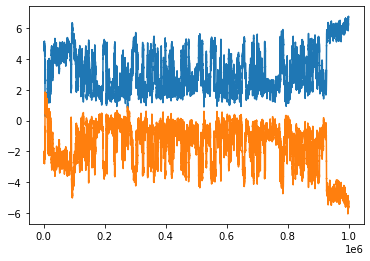

In [185]:
player1 = Player(1, 
                 alpha = 0.3, 
                 gamma = 0.5,
                 epsilon = 0.3)
player2 = Player(-1, 
                 alpha = 0.3,
                 gamma = 0.5, 
                 epsilon = 0.3)

# Training the policy
player1, player2, p1_rewards, p2_rewards = play_tictactoe(1000000, player1, player2, verbose=False)
print('\n')
print(len(player1.get_qtable()))
print(len(player2.get_qtable()))
pd.Series(p1_rewards).rolling(1000).mean().plot()
pd.Series(p2_rewards).rolling(1000).mean().plot()

In [ ]:
player1.get_qtable()

In [ ]:
# Validating the model. Setting epsilon to 0 ensures always using the optimal strategy

player1.set_params(epsilon = 0)
random_player = Player(1, epsilon=1.0)
player2.set_params(epsilon = 0)

player1, player2, p1_rewards, p2_rewards = play_tictactoe(10, player1, player2, verbose=False)
pd.Series(p1_rewards).mean()

In [ ]:
player1.get_qtable()

In [ ]:
tictactoe = Tictoe(3)

print('''Welcome to TicTacToe. 

You can make a move by selecting one of the following letters:''')
letters = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i']
print(np.array(letters).reshape(3,3))
print('''You start, the computer will take the next move

Initial board:''')

player1.set_params(epsilon = 0)
move_history = ''
while not tictactoe.is_endstate():
    print('Computer is thinking')
    tictactoe = player1.make_move(tictactoe, {}, verbose=True)
    print(tictactoe.get_board())
    
    if not tictactoe.is_endstate():
        player_move = input('Your move!: ')
        tictactoe.make_move(-1, player_move)
        print(tictactoe.get_board())

In [194]:
import dill

with open('player1_block_aebc.pkl', 'wb') as player_file:
    dill.dump(player1, player_file)

# Wat te doen
We should:
- play the game tictactoe with an empty state-action table
- let the computer play against itself
- when the game ends (win a, win b or loss) the reward for the given player is backpropagated through the network of possible states. 

\begin{equation}
Q^{new}(s_t, a_t) \leftarrow Q(s_t, a_t) + \alpha (r_t + \gamma \cdot \max_a(s_{t+1}, a) - Q(s_t, a_t))
\end{equation}

where:

- $Q^{new}(s_t, a_t)$, is the new Q-value for the given action-value pair for state $s_t$ and action $a_t$. 
- $Q(s_t, a_t)$, the previous Q-value that was recorded in the Q-table.
- $\alpha$ the learning rate. How heavily should the new Q-value be influenced by what we are going to learn in this new step?
- $r_t$ the (short-term) reward we got for taking the $\epsilon$-greedy step. 
- $max_a(s_{t+1}, a)$ is the estimate of optimal future value for state $s_{t+1}$, i.e. the maximum Q value for that state $s_{t+1}$. 

A slight rewrite of the function yields additional insight:

\begin{equation}
Q^{new}(s_t, a_t) \leftarrow (1-\alpha) Q(s_t, a_t) + \alpha r_t + \alpha\gamma \max_a(s_{t+1}, a)
\end{equation}

where:
- $(1-\alpha) Q(s_t, a_t)$ is the current value of Q weighted by the learning rate. So, if the learning rate is zero, the new value is simply the old value. This essentially means the algorithm is not learning anything new. An alpha value of 1 simply discards this old value and completely relies on the new Q value calculated by the other terms. Values in between 0 and 1 allow you to control how fast learning progresses. A balance between learning fast enough, but not getting overly focused on short term gains is part of the challenge. 
- $\alpha r_t$ the short-term reward we got from taking the $\epsilon$-greedy action we took. Like before, an $\alpha$ of 1 ensures completely focusing on the short-term reward, and an $\alpha$ of 0 completely disregards what reward we got. 
- $\alpha\gamma \max_a(s_{t+1}, a)$ the largest potential future Q-value we could obtain in the actions that follow this particular state. It hints towards the potential (long-term) value taking action $a_t$ in state $s_t$. 

So, to update the value $Q$ of taking action $a_t$ given a state $s_t$ we balance the old value we got versus the short term reward and the potential long-term value the next steps after this action provides. 